# Model discovery from multiple experiments

## Chaotic and pre-chaotic regimes

In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.6'

import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("white")
from time import time

from sklearn.model_selection import train_test_split
from sklearn.utils.random import sample_without_replacement
from sklearn.utils import shuffle,resample
from sklearn.linear_model import Ridge

import jax
from jax import random, numpy as jnp
from flax import optim
from flax.core import freeze, unfreeze

import sys
sys.path.append('pdeX')
from sparsity_estimators import ir_cond,ir_condAL, get_mask_multi
from DeepModx import pdeX, create_update_state, loss_fn_pinn_multi2, mse_test,mask_scheduler, Logger, Convergence

# General params

In [2]:
key = random.PRNGKey(21)
np.random.seed(42)

In [3]:
# Data
noise_level = 0.2
number_of_samples = 2000
path = 'logs/chaos_GL' # path to log tensorboard files

x     = np.load('data/KS_x.npy')
t     = np.load('data/KS_t.npy')
u     = np.array(np.load('data/KS_u.npy'),dtype=np.float32)


scale_in=[[x.max(),t.max()],[x.max(),t.max()]]


# DeepMod parameters
# neural net architecture
nn_shared_features = []
nn_specific_features = [65,65,65,65,1]

# learning parameters
deltaSP = 1e-5 # target MSE on test set before triggering sparsity for the first time
deltaC = 1e-2  # converge criterion
learning_rate = 5e-5
max_epochs = 1.5e5+1

# logging
write_tensorboard = True


In [4]:
sparsity_method = 'GL'
randomized = True

# Input data with some noise

In [5]:
noise_l = noise_level*np.std(u)*np.random.randn(u.shape[0],u.shape[1])
u_noisy = u + noise_l

In [6]:
x_grid,  t_grid = jnp.meshgrid(x,  t, indexing="ij")

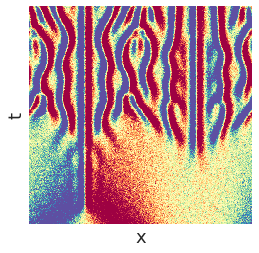

In [7]:
fig,ax = plt.subplots(1,1, figsize=(4,4))

bx = sns.heatmap(u_noisy.T,ax=ax,vmin=-1,vmax=1,cmap='Spectral',cbar=False)
bx.invert_yaxis()    
bx.set_xticks([])
bx.set_yticks([])

ax.set_xlabel('x')
ax.set_ylabel('t');

6720

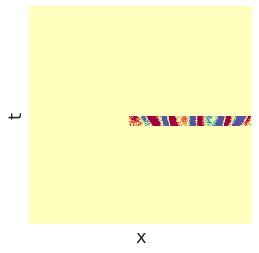

In [8]:
idx_g1 = np.logical_and(t_grid>45,t_grid<50)
idx_g2 = np.logical_and(idx_g1,x_grid>45)
idx_g3 = np.logical_and(idx_g2,x_grid<100)

mask0 = np.zeros_like(idx_g3)
mask0[idx_g3] = 1

fig,ax = plt.subplots(1,1, figsize=(4,4))

bx = sns.heatmap((u_noisy*mask0).T,ax=ax,vmin=-1,vmax=1,cmap='Spectral',cbar=False)
bx.invert_yaxis()    
bx.set_xticks([])
bx.set_yticks([])

ax.set_xlabel('x')
ax.set_ylabel('t');
idx_g3.sum()

6720

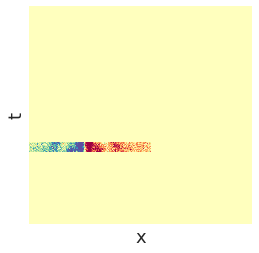

In [9]:
idx_g1 = np.logical_and(t_grid>33,t_grid<38)
idx_g2 = np.logical_and(idx_g1,x_grid>0)
idx_g3 = np.logical_and(idx_g2,x_grid<55)

mask1 = np.zeros_like(idx_g3)
mask1[idx_g3] = 1

fig,ax = plt.subplots(1,1, figsize=(4,4))

bx = sns.heatmap((u_noisy*mask1).T,ax=ax,vmin=-1,vmax=1,cmap='Spectral',cbar=False)
bx.invert_yaxis()    
bx.set_xticks([])
bx.set_yticks([])

ax.set_xlabel('x')
ax.set_ylabel('t');
idx_g3.sum()

0 559
83 94


[]

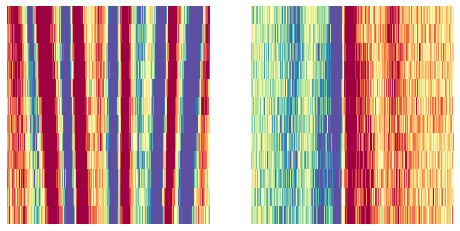

In [10]:
xini = np.where(mask1>0)[0][0]
xfin = np.where(mask1>0)[0][-1]
tini = np.where(mask1>0)[1][0]
tfin = np.where(mask1>0)[1][-1]
print(xini,xfin)
print(tini,tfin)

nxx = np.arange(xini,xfin).shape[0]+1
ntt = np.arange(tini,tfin).shape[0]+1

fig,ax = plt.subplots(1,2, figsize=(8,4))

bx = sns.heatmap((u_noisy[mask0].reshape(nxx,ntt).T), ax=ax[0],vmin=-1,vmax=1,cmap='Spectral',cbar=False)
bx.invert_yaxis()    
bx.set_xticks([])
bx.set_yticks([])

bx = sns.heatmap((u_noisy[mask1].reshape(nxx,ntt).T), ax=ax[1],vmin=-1,vmax=1,cmap='Spectral',cbar=False)
bx.invert_yaxis()    
bx.set_xticks([])
bx.set_yticks([])


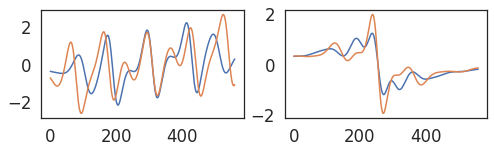

In [11]:
fig,ax = plt.subplots(1,2, figsize=(8,2))

ax[0].plot((u[mask0].reshape(nxx,ntt).T)[0,:])
ax[0].plot((u[mask0].reshape(nxx,ntt).T)[-1,:])

ax[1].plot((u[mask1].reshape(nxx,ntt).T)[0,:])
ax[1].plot((u[mask1].reshape(nxx,ntt).T)[-1,:])

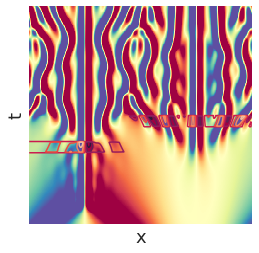

In [12]:
fig,ax = plt.subplots(1,1, figsize=(4,4))



bx = sns.heatmap(u.T,ax=ax,vmin=-1,vmax=1,cmap='Spectral',cbar=False)
bx.invert_yaxis()    
bx.set_xticks([])
bx.set_yticks([])

ax.set_xlabel('x')
ax.set_ylabel('t');


ax.contour((u*mask0).T)
ax.contour((u*mask1).T)

In [13]:
idx = resample(np.arange(u_noisy[mask0].shape[0]),replace=False,random_state=0,n_samples=number_of_samples)


u1_noisy_shuffled = (u_noisy[mask0])[idx]
u2_noisy_shuffled = (u_noisy[mask1])[idx]

xs = ((x_grid[mask0])[idx]).reshape(-1,1)
ts = ((t_grid[mask0])[idx]).reshape(-1,1)


In [14]:

scale_from_outputs = []
u_d = []

# scaling and subsampling
u_sampled1 = u1_noisy_shuffled.reshape(-1,1)
u_max1 = u_sampled1.max()
scale_from_outputs.append(u_max1)
u_d.append(u_sampled1/u_max1)


u_sampled2 = u2_noisy_shuffled.reshape(-1,1)
u_max2 = u_sampled2.max()
scale_from_outputs.append(u_max2)
u_d.append(u_sampled2/u_max2)


In [15]:
X_data = jnp.concatenate([ts/t.max(),xs/x.max()],axis=1)
y_data = jnp.concatenate([np.array(u_d[0]),np.array(u_d[1])],axis=1)

In [16]:
print(X_data.shape)
print(y_data.shape)

(2000, 2)
(2000, 2)


In [17]:
n_out = y_data.shape[1]
n_out

2

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Model initialization and parameters

In [19]:
# Instantiating model and optimizers
model = pdeX(nn_shared_features, nn_specific_features, n_out)
optimizer = optim.Adam(learning_rate=learning_rate, beta1=0.99, beta2=0.99)
logger = Logger(path)
converged = Convergence(delta=deltaC)

In [20]:
sparsity_scheduler = [mask_scheduler(delta=deltaSP) for i in range(n_out)]
sparsity_scheduler_group = mask_scheduler(delta=deltaSP)

In [21]:
# initializing
variables = model.init(key, X_train)
state, params = variables.pop('params')
y, updated_state = model.apply(variables, X_train, mutable=['coeffs_mask'])
optimizer = optimizer.create(params)
# compiling train step
update = create_update_state(loss_fn_pinn_multi2, model=model, x=X_train, y=y_train)
_ = update(optimizer, state)  # triggering compilation

# Training 

In [22]:

t_start = time()
counter = 0
for epoch in jnp.arange(max_epochs):

    # updating the model
    (optimizer, state), metrics, dt, theta, coeffs, coeffs_mask = update(optimizer, state)
    if epoch % 500 == 0:
        print(f"Loss step {epoch}: {metrics['mse']}")
    
    if epoch % 25 == 0:   

        # computing losses on test set, masks are set individually
        loss_test, loss_test_exp_wise = mse_test(model, optimizer.target, state, X_test, y_test)
        loss_test_metric = {'loss_test':loss_test_exp_wise}
        
        
        if write_tensorboard:
            metrics = {**metrics, **loss_test_metric}
            logger.write(metrics, epoch)

        update_sparsity, optimizer = sparsity_scheduler_group(loss_test, epoch, optimizer)
        
        # Loss on test set has increased, triggering the update of the mask
        if update_sparsity:
            ############################################################################################
            ############################################################################################
            if counter == 0:
                np.save(path +'/theta_IN',theta)
                np.save(path +'/dt_IN',dt)
                counter = 1
                print('sparsity at ', epoch)

            # computing new state to feed model
            mask,maxP_selec = get_mask_multi(theta,dt,method=sparsity_method,randomized=randomized)    
            more_metrics = {'prob_selec':maxP_selec}
            logger.write(more_metrics, epoch)

            ############################################################################################
            ############################################################################################

            state = freeze({'coeffs_mask': {'maskC': jnp.array(mask)}})
        
        if converged(epoch, coeffs):
            print(f'Converged at epoch {epoch}')

            np.save(path +'/theta_FIN',theta)
            np.save(path +'/dt_FIN',dt)

            break

logger.close()
t_end = time()
print(t_end - t_start)

############################################################################################
############################################################################################                    

Loss step 0.0: 0.24307982623577118
Loss step 500.0: 0.03499162197113037
Loss step 1000.0: 0.026603106409311295
Loss step 1500.0: 0.021631591022014618
Loss step 2000.0: 0.019312314689159393
Loss step 2500.0: 0.018082622438669205
Loss step 3000.0: 0.017412319779396057
Loss step 3500.0: 0.0170064065605402
Loss step 4000.0: 0.016725802794098854
Loss step 4500.0: 0.016520382836461067
Loss step 5000.0: 0.016358759254217148
Loss step 5500.0: 0.016221821308135986
Loss step 6000.0: 0.01611865498125553
Loss step 6500.0: 0.016020895913243294
Loss step 7000.0: 0.015943562611937523
Loss step 7500.0: 0.015871811658143997
Loss step 8000.0: 0.01581309363245964
Loss step 8500.0: 0.015745818614959717
Loss step 9000.0: 0.01569184474647045
Loss step 9500.0: 0.0156356543302536
Loss step 10000.0: 0.015597192570567131
Loss step 10500.0: 0.015552770346403122
Loss step 11000.0: 0.015515277162194252
Loss step 11500.0: 0.015476370230317116
Loss step 12000.0: 0.015439918264746666
Loss step 12500.0: 0.015408566221

In [23]:
new_params = optimizer.target
new_variables = freeze({'params': new_params.unfreeze(), **state.unfreeze()})
uu_train = model.apply(new_variables,X_train,mutable=['coeffs_mask'])[0]
coeffs = uu_train[3]

In [24]:
def X_new(nx,nt):
    x1 = jnp.linspace(x.min(), x.max(), nx)
    t1 = jnp.linspace(t.min(), t.max(), nt)    
    t_grid, x_grid = jnp.meshgrid(t1, x1, indexing="ij")
    Xnn = jnp.concatenate([(t_grid/t.max()).reshape(-1, 1), (x_grid/x.max()).reshape(-1, 1)], axis=1)

    return Xnn

nx = 100
nt = 100
uu = model.apply(new_variables, X_new(nx,nt), mutable=list(state.keys()))[0]

# Library and recovered PDEs

In [26]:
name_feats = ['1',
r'$u_x$',
r'$u_{xx}$',
r'$u_{xxx}$',
r'$u_{xxxx}$',
r'$u_{xxxxx}$',
r'$u$',
r'$uu_x$',
r'$uu_{xx}$',
r'$uu_{xxx}$',
r'$uu_{xxxx}$',
r'$uu_{xxxxx}$',
r'$u^2$',
r'$u^2u_x$',
r'$u^2u_{xx}$',
r'$u^2u_{xxx}$',
r'$u^2u_{xxxx}$',
r'$u^2u_{xxxxx}$',
r'$u^3$',
r'$u^3u_x$',
r'$u^3u_{xx}$',
r'$u^3u_{xxx}$',
r'$u^3u_{xxxx}$',
r'$u^3u_{xxxxx}$',
r'$u^4$',
r'$u^4u_x$',
r'$u^4u_{xx}$',
r'$u^4u_{xxx}$',
r'$u^4u_{xxxx}$',
r'$u^4u_{xxxxx}$',
r'$u^5$',
r'$u^5u_x$',
r'$u^5u_{xx}$',
r'$u^5u_{xxx}$',
r'$u^5u_{xxxx}$',
r'$u^5u_{xxxxx}$']

In [27]:
xi = coeffs[:,:,0]

In [28]:

xiS = []

for i, vCoeff in enumerate(xi):


    xmax = scale_in[i][0]
    tmax = scale_in[i][1]
    
    scaleX = np.tile(np.array([1,xmax,xmax**2,xmax**3,xmax**4,xmax**5]),6)
    scaleUT = scale_from_outputs[i]/tmax
    
    
    scaleU1 = np.tile(np.array(1/scale_from_outputs[i]),36)
    scaleU1[0] = 1
    
    scaleU2 = np.repeat(np.array([1,1/scale_from_outputs[i],1/scale_from_outputs[i]**2,1/scale_from_outputs[i]**3,1/scale_from_outputs[i]**4,1/scale_from_outputs[i]**5]),6)
    
    xiS.append( vCoeff * scaleUT * scaleX *  scaleU1 * scaleU2)

xiS = np.array(xiS).T
xiS

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [-0.82820432, -0.80417084],
       [ 0.        ,  0.        ],
       [-0.82154024, -0.74721432],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [-0.85056564, -0.7085089 ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,

In [29]:
np.save(path +'/scale_from_outputs',scale_from_outputs)

import pickle
a_file = open(path + "/new_params.pkl", "wb")
pickle.dump(new_params.unfreeze(), a_file)
a_file.close()

a_file = open(path + "/state.pkl", "wb")
pickle.dump(state.unfreeze(), a_file)
a_file.close()

np.save(path +'/X_train',X_train)